In [20]:
import os
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import collections
from datetime import datetime
from collections import Counter
import seaborn as sns
from statistics import median
from statistics import mean
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

In [21]:
# obscure all footprint ("data" field) in context = "/login", "/profile", and "createPost"
filePath = "userLog (5 May 22)"
savePath = "userLog (5 May 22, obscured)"
for i in os.listdir(filePath):
    data = ""
    with open(filePath+"/"+i, "r") as f:
        for line in f.readlines():
            jsonData = json.loads(line)
            if jsonData['context'] == "/login" or jsonData['context'] == "/profile" or jsonData['context'] == "createPost":
                jsonData['data'] = {"text": "data-obscured", "desc": "data-obscured"}
            data += json.dumps(jsonData)+"\n"
    with open(savePath+"/"+i, "w") as f:
        f.write(data)

In [22]:
filePath = "userLog (5 May 22, obscured)"
rawDumps = []
for i in os.listdir(filePath):
    with open(filePath+"/"+i, 'r') as f:
        rawDumps += [json.loads(line) for line in f.read().splitlines()]

In [23]:
rawDumps[0]

{'id': 0,
 'dateTime': '2021-10-27 16:09:58.206',
 'isWeb': 1,
 'tmpUserID': 10,
 'userID': None,
 'context': '/',
 'data': [],
 'action': 'nav'}

In [24]:
print(set([i['action'] for i in rawDumps])) # all possible actions
print(set([i['data']['text'] for i in rawDumps if i['action'] == 'click'])) # all possible clicks
print(set([i['isWeb'] for i in rawDumps]))

{'textSelected', 'changeTab', 'textInput', 'popping', 'click', 'nav', 'textfieldFocus', 'initTab'}
{'Actin-DAPI.pdf', 'Agree', 'BTS-TELEMG multichannel electro-myographic system', 'My Profile', 'Discard post and exit?', 'Lab Access Guide', 'Prototyping Tutorial', 'Cell Area Calculations', 'Gelatin coating Protocol.pdf', 'TEM imaging.pdf', 'Icons.arrow_back', 'Welcome to the forum of BME Student Database', 'Microplate Reader (Synergy)', 'data-obscured', 'Contact', 'Facilities', 'Centrifuge (NUWIND)', 'Picogreen Standard Curve', 'Licensed IDEs (Matlab; VS Studio)', 'AMTI force plates for gait analysis', 'Select Equipment:', 'Username changed successfully.', 'General Lab Access Guide', 'Login', 'Go To Booking', 'Select Date:', 'Select Time (Maximum 3 hours per day):', 'Circuit Development Toolkits', 'Osteogenesis Assay.pdf', 'Arduino Web Tutorial', 'VS Studio Free', 'Yes', 'Z to A', 'Other Labs', 'Experiment Protocols', 'ImageJ viability and image merging.pdf', 'Booking', 'Check Protocol'

In [43]:
# convert to table
df = defaultdict(list)
for record in rawDumps:
    if record['action'] != 'click' and record['action'] != 'nav': continue
    #if record['dateTime'].split(" ")[0] == '2021-10-26': continue    
    df['id'].append(record['id'])
    df['dt'].append(record['dateTime'])
    df['date'].append(record['dateTime'].split(" ")[0])
    df['time'].append(record['dateTime'].split(" ")[1])
    df['tmpUserID'].append(record['tmpUserID'])
    df['userID'].append(record['userID'])
    df['context'].append(False if record['context'] is None else record['context'].split("?")[0])
    df['fullContext'].append(record['context'])
    if record['action'] == 'nav':
        df['data-text'].append(False)
    else:
        df['data-text'].append(record['data']['text'])    
    df['action'].append(record['action'])
    #df['email'].append(None if record['tmpUserID'] not in userMailMapping else userMailMapping[record['tmpUserID']])
    df['email'].append('data-obscured')
    
df = pd.DataFrame(df)

# data cleaning
df.fillna(False, inplace=True)
for userID in set(df['userID']):
    if userID == False: continue
    allTmpUserIDs = list(set(df[df['userID'] == userID]['tmpUserID']))
    for tmpUserID in allTmpUserIDs:
        df['tmpUserID'].replace(tmpUserID, allTmpUserIDs[0], inplace=True)
#df = df[df['tmpUserID'] != 33]

# clean also those somehow missing id=0 (one shouldn't be able to skip initial session logging)
for userID in set(df['tmpUserID']):
    if 0 not in set(df[df['tmpUserID'] == userID]['id'].tolist()):
        df = df[df['tmpUserID'] != userID]

# add isReg col
allTmpUserID = list(set(df['tmpUserID']))
hasReg = [True if len(set(df[df['tmpUserID'] == tmpID]['userID'])) > 1 else False for tmpID in allTmpUserID]
hasReg = dict(zip(allTmpUserID, hasReg))
hasRegCol = [hasReg[tmpUserID] for tmpUserID in df['tmpUserID'].tolist()]
df['hasReg'] = hasRegCol
df.sort_values(by=['dt'], inplace=True, ignore_index=True)

# add initialVisit col
initialVisit = []
for tmpUserID in allTmpUserID:
    sessStartIs = df[(df['tmpUserID'] == tmpUserID) & (df['id'] == 0)].index.values.tolist()
    if len(sessStartIs) == 1: 
        initialVisit += df[df['tmpUserID'] == tmpUserID].index.values.tolist()
    else:
        thresI = sessStartIs[1]
        initialVisit += df[(df['tmpUserID'] == tmpUserID) & (df.index < thresI)].index.values.tolist()
initialVisit = set(initialVisit)
isInitial = [True if i in initialVisit else False for i in range(len(df))]
df['isInitial'] = isInitial

# add sess
sessID = []
isInSess = {} # to add session id
curMaxSessId = 0
for i, row in df.iterrows():
    if row['id'] == 0:
        isInSess[row['tmpUserID']] = curMaxSessId
        curMaxSessId += 1
    if row['tmpUserID'] not in isInSess: continue
    sessID.append(isInSess[row['tmpUserID']])
df['sessID'] = sessID

# define remote desktop as nav
for i in df.index:
    if df.iloc[i]['data-text'] == 'Remote Desktop':
        df.at[i, 'context'] = 'Remote Desktop'
        df.at[i, 'action'] = 'nav'

df

,id,dt,date,time,tmpUserID,userID,context,fullContext,data-text,action,email,hasReg,isInitial,sessID
0,0,2021-10-26 10:19:15.928,2021-10-26,10:19:15.928,4,False,/,/,False,nav,data-obscured,True,True,0
1,0,2021-10-27 05:04:25.722,2021-10-27,05:04:25.722,7,False,/,/,False,nav,data-obscured,True,True,1
2,1,2021-10-27 05:04:27.782,2021-10-27,05:04:27.782,7,False,/,/,Forum,click,data-obscured,True,True,1
3,2,2021-10-27 05:04:27.794,2021-10-27,05:04:27.794,7,False,/discuss,/discuss,False,nav,data-obscured,True,True,1
4,3,2021-10-27 05:04:29.522,2021-10-27,05:04:29.522,7,False,/discuss,/discuss,Laboratories of the PolyU BME Database,click,data-obscured,True,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,2022-04-26 14:25:43.215,2022-04-26,14:25:43.215,81,False,/,/,False,nav,data-obscured,False,True,140
860,1,2022-04-26 14:25:47.141,2022-04-26,14:25:47.141,81,False,Remote Desktop,/,Remote Desktop,nav,data-obscured,False,True,140
861,0,2022-04-29 16:53:29.640,2022-04-29,16:53:29.640,80,False,/,/,False,nav,data-obscured,False,False,141
862,1,2022-04-29 16:53:33.976,2022-04-29,16:53:33.976,80,False,Remote Desktop,/,Remote Desktop,nav,data-obscured,False,False,141


In [44]:
print(set(df['userID']))
print(set(df['context']))
print(len(set(df['tmpUserID'])))
print(len(df[df['data-text'] == 'Remote Desktop']))

{False, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0}
{False, '/discuss', '/info', '/contact', '/booking', '/profile', '/createPost', '/post', 'Remote Desktop', '/pdfview', '/', '/login'}
67
74


# statistics

In [45]:
# all logged date
tmp = sorted(set(df[df['id'] == 0]['date']))
print(tmp, len(tmp))

['2021-10-26', '2021-10-27', '2021-10-28', '2021-10-29', '2021-10-31', '2021-11-01', '2021-11-02', '2021-11-03', '2021-11-05', '2021-11-08', '2021-11-09', '2021-11-10', '2021-11-11', '2021-11-12', '2021-11-14', '2021-11-15', '2021-11-16', '2021-11-19', '2021-11-21', '2021-11-23', '2021-11-26', '2021-12-02', '2021-12-09', '2021-12-13', '2021-12-16', '2021-12-28', '2022-01-06', '2022-01-07', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16', '2022-01-17', '2022-01-18', '2022-01-19', '2022-01-20', '2022-01-23', '2022-01-24', '2022-01-26', '2022-02-09', '2022-02-11', '2022-02-21', '2022-04-14', '2022-04-15', '2022-04-19', '2022-04-24', '2022-04-26', '2022-04-29', '2022-05-23'] 50


# statistics for publication

In [46]:
def get_sorted_dur(df):
    allDurations = [] # each session, in minutes
    for tmpUserID in set(df['tmpUserID']):
        user_df = df[df['tmpUserID'] == tmpUserID]
        user_df.sort_values(by=['dt'], inplace=True)
        user_dts, user_ids = user_df['dt'].tolist(), user_df['id'].tolist()
        checkPts = [i for i in range(len(user_ids)) if user_ids[i] == 0]
        # get duration of each session
        user_dts = [datetime.strptime(dt.split(".")[0], '%Y-%m-%d %H:%M:%S') for dt in user_dts] # convert to dt
        for i in range(len(checkPts)): # get diff in start & end of each session: duration
            if i == len(checkPts)-1:
                startDT, endDT = user_dts[checkPts[i]], user_dts[-1]
            else:
                startDT, endDT = user_dts[checkPts[i]], user_dts[checkPts[i+1]-1]
            allDurations.append(int((endDT-startDT).total_seconds()))
    x = np.asarray(sorted(allDurations))
    return x

In [47]:
# bounce rate: exit immediately after front page
# single-page visit: exit only one page visit
# check the length of each session then know (click = single-page visit = length 1, bounce rate = length 0)
sessNum = len(set(df['sessID'].tolist()))
bounceCount, singleCount = 0, 0
sessCount = len(set(df['sessID'].tolist()))
for sess in set(df['sessID'].tolist()):
    sessLen = len(df[df['sessID'] == sess].index.tolist())
    if sessLen == 1: bounceCount += 1
    if sessLen == 2: singleCount += 1
print("sessNum: {}, bounce rate: {}, +1 bounce rate: {}".format(sessNum, bounceCount/sessCount, singleCount/sessCount))

sessNum: 143, bounce rate: 0.3076923076923077, +1 bounce rate: 0.23076923076923078


In [48]:
# recurring user: tmpUserID with more than one id=0
# user: tmpUserID
# registered user: tmpUserID with userID and email
allTmpUsers = set(df['tmpUserID'].tolist())
recurUsers = set()
regUsers = set()
for tmpUser in allTmpUsers:
    if len(df[(df['tmpUserID'] == tmpUser) & (df['id'] == 0)].index.tolist()) > 1:
        recurUsers.add(tmpUser)
    if len(df[(df['tmpUserID'] == tmpUser) & (df['userID'] != False)].index.tolist()) >= 1:
        regUsers.add(tmpUser)
print(len(allTmpUsers), len(recurUsers), len(regUsers))
print(len(allTmpUsers&recurUsers&regUsers), len(allTmpUsers&recurUsers),
      len(allTmpUsers&regUsers), len(recurUsers&regUsers))
print(len(allTmpUsers-recurUsers-regUsers), len(recurUsers-allTmpUsers-regUsers),
      len(regUsers-recurUsers-allTmpUsers))
print(len((recurUsers&regUsers)-allTmpUsers), len((recurUsers&allTmpUsers)-regUsers),
      len((regUsers&allTmpUsers)-recurUsers))

67 26 7
4 26 7 4
38 0 0
0 22 3


# figures

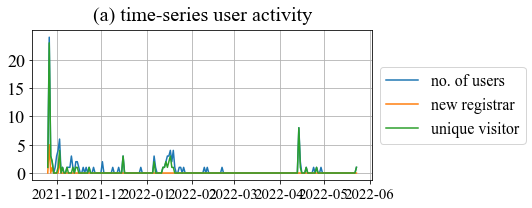

In [49]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=16)
plt.rcParams["font.family"] = "Times New Roman"

dates = sorted(list(set(df['date'].tolist())))
allDates = pd.date_range(start=dates[0], end=dates[-1])
x, y1, y2, y3 = allDates, [], [], []
newUsers = set()
for i in x:
    tmp_df = df[df['date'] == str(i).split(" ")[0]]
    y1.append(len(set(tmp_df['tmpUserID'].tolist())))
    
    oldUserNum = len(newUsers)
    userIDs = set(tmp_df['userID'].tolist())-{False}
    newUsers.update(userIDs)
    newUserNum = len(newUsers)
    newReg = newUserNum-oldUserNum
    y2.append(newReg)
    
    # unique visitor
    ttmp_df = tmp_df.drop_duplicates(subset=['tmpUserID'])
    y3.append(len(ttmp_df[ttmp_df["isInitial"] == True].index))
    
fig = plt.figure(figsize=(7.5,3))
plt.plot(x, y1, label='no. of users')
plt.plot(x, y2, label='new registrar')
plt.plot(x, y3, label='unique visitor')
ax = plt.gca()
ax.grid(axis='both')
plt.yticks([0, 5,10,15,20])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("(a) time-series user activity", pad=10)
fig.tight_layout()
fig.savefig("./img/time_user_raw.png", dpi=300)

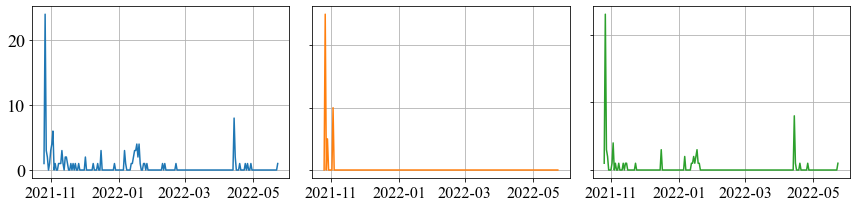

In [50]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=16)
plt.rcParams["font.family"] = "Times New Roman"

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(x, y1, color='tab:blue')
axes[1].plot(x, y2, color='tab:orange')
axes[2].plot(x, y3, color='tab:green')

for i in range(0, 3):
    axes[i].xaxis.set_major_locator(mdates.MonthLocator((11, 1, 3, 5)))
    axes[i].grid(axis='both')
    
axes[1].yaxis.set_ticklabels([])
axes[2].yaxis.set_ticklabels([])

fig.tight_layout()
fig.savefig("./img/time_user.png", dpi=300)

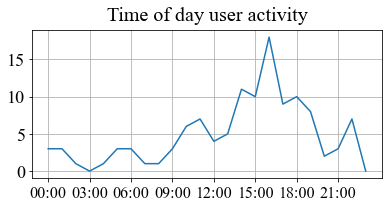

In [51]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=16)
plt.rcParams["font.family"] = "Times New Roman"

dates = sorted(list(set(df['date'].tolist())))
allTimes = ["0{}:00:00.000".format(str(i)) if i < 10 else "{}:00:00.000".format(str(i)) for i in range(0, 24)]
allTimes += ["00:00:00.000"]
y1 = []
newUsers = set()
for i in range(len(allTimes)-1):
    tmp_df = df[np.logical_and(df['time'] >= allTimes[i], df['time'] < allTimes[i+1])]
    y1.append(len(set(tmp_df['tmpUserID'].tolist())))
    
x = ["0{}:00".format(str(i)) if i < 10 else "{}:00".format(str(i)) for i in range(0, 24)]
fig = plt.figure(figsize=(5.5,3))
plt.plot(x, y1, label='no. of users')
ax = plt.gca()
ax.grid(axis='both')
ax.set_xticks(["0{}:00".format(str(i)) if i < 10 else "{}:00".format(str(i)) for i in range(0, 24, 3)])
ax.set_title("Time of day user activity", pad=10)
fig.tight_layout()
fig.savefig("./img/clock_user.png", dpi=300)

mean: 2, median: 1, 75% quartile: 2, max val: 17
how many above 75%: 26, 90% quartile: 4, how many above 90%: 9
67


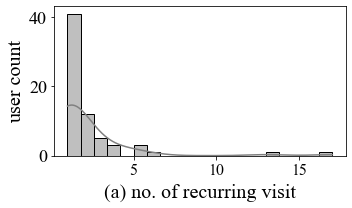

In [53]:
tmp_df = df[df['id'] == 0]['tmpUserID'].tolist()
recurVisit = dict(Counter([i for i in tmp_df]))
x = list(recurVisit.values())
x = np.asarray(sorted(x))
print("mean: {}, median: {}, 75% quartile: {}, max val: {}".format(
    mean(x), median(x), x[int(len(x)*0.75)], np.max(x)
))
print("how many above 75%: {}, 90% quartile: {}, how many above 90%: {}".format(
    len(x[x >= x[int(len(x)*0.75)]]), x[int(len(x)*0.9)], len(x[x >= x[int(len(x)*0.9)]])
))
print(len(x))
topRecurThres = x[int(len(x)*0.75)]

fig = plt.figure(figsize=(5,3))
sns.histplot(data=x, kde=True, bins=20, label='', color='grey')
ax = plt.gca()
ax.set_xlabel("(a) no. of recurring visit")
ax.set_ylabel("user count")
#plt.legend()
plt.tight_layout()
plt.savefig("./img/recurr_details.png", dpi=300)
plt.show()

C:\Users\andy8\AppData\Local\Temp\ipykernel_49040\1735034918.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df.sort_values(by=['dt'], inplace=True)


number of full records: 143
number of records after filtering (1-hour): 137
mean: 115, median: 6, 75% quartile: 58, max val: 3216
how many above 75%: 35, 90% quartile: 177, how many above 90%: 14
137


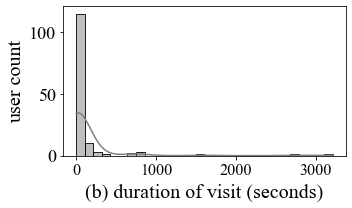

In [54]:
x = get_sorted_dur(df)
print("number of full records: {}".format(len(x)))
x = x[x < 60*60]
print("number of records after filtering (1-hour): {}".format(len(x)))
print("mean: {}, median: {}, 75% quartile: {}, max val: {}".format(
    mean(x), median(x), x[int(len(x)*0.75)], np.max(x)
))
print("how many above 75%: {}, 90% quartile: {}, how many above 90%: {}".format(
    len(x[x >= x[int(len(x)*0.75)]]), x[int(len(x)*0.9)], len(x[x >= x[int(len(x)*0.9)]])
))
print(len(x))
topDurThres = x[int(len(x)*0.75)]

fig = plt.figure(figsize=(5,3))
sns.histplot(data=x, kde=True, label='no. of visit', bins=30, color='grey')
ax = plt.gca()
#plt.legend()
ax.set_xlabel('(b) duration of visit (seconds)')
ax.set_ylabel('user count')
plt.tight_layout()
plt.savefig("./img/dur_details.png", dpi=300)
plt.show()

In [55]:
print("duration: {}, recurring: {}".format(topDurThres, topRecurThres))

duration: 58, recurring: 2


In [56]:
# map tmpUserID to recurVisit
# also map tmpUserID to a list of duration
# then filter tmpUserID such that either their recurVisit >= topRecurThres
# or has one duration >= topDurThres
tmp_df = df[df['id'] == 0]['tmpUserID'].tolist()
recurVisit = dict(Counter(tmp_df))

allDurations = defaultdict(list)
for tmpUserID in set(df['tmpUserID']):
    user_df = df[df['tmpUserID'] == tmpUserID]
    user_df.sort_values(by=['dt'], inplace=True)
    user_dts, user_ids = user_df['dt'].tolist(), user_df['id'].tolist()
    checkPts = [i for i in range(len(user_ids)) if user_ids[i] == 0]
    # get duration of each session
    user_dts = [datetime.strptime(dt.split(".")[0], '%Y-%m-%d %H:%M:%S') for dt in user_dts] # convert to dt
    for i in range(len(checkPts)): # get diff in start & end of each session: duration
        if i == len(checkPts)-1:
            startDT, endDT = user_dts[checkPts[i]], user_dts[-1]
        else:
            startDT, endDT = user_dts[checkPts[i]], user_dts[checkPts[i+1]-1]
        allDurations[tmpUserID].append(int((endDT-startDT).total_seconds()))
for key in allDurations:
    allDurations[key] = np.max(allDurations[key])

validRecUIDs = set([key for key in recurVisit if recurVisit[key] >= topRecurThres])
validDurUIDs = set([key for key in allDurations if allDurations[key] >= topDurThres])
activeTmpUIDs = validRecUIDs&validDurUIDs
print(len(activeTmpUIDs))
print(len(set(df['tmpUserID'].tolist())))

15
67


C:\Users\andy8\AppData\Local\Temp\ipykernel_49040\1008987946.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df.sort_values(by=['dt'], inplace=True)


In [57]:
active_df = df[df['tmpUserID'].isin(activeTmpUIDs)]
nonactive_df = df[~df['tmpUserID'].isin(activeTmpUIDs)]
print("active user session no.: {}, nonactive user session no.: {}".format(
len(active_df[active_df['id'] == 0].index), len(nonactive_df[nonactive_df['id'] == 0])))

active_recur = list(dict(Counter(active_df[active_df['id'] == 0]['tmpUserID'].tolist())).values())
nonactive_recur = list(dict(Counter(nonactive_df[nonactive_df['id'] == 0]['tmpUserID'].tolist())).values())
print("mean active recur: {}, mean nonactive recur: {}".format(mean(active_recur), mean(nonactive_recur)))

active_dur = get_sorted_dur(active_df)
active_dur = active_dur[active_dur < 60*60]
nonactive_dur = get_sorted_dur(nonactive_df)
nonactive_dur = nonactive_dur[nonactive_dur < 60*60]
print("mean active dur: {}, mean nonactive dur: {}".format(mean(active_dur), mean(nonactive_dur)))

active user session no.: 62, nonactive user session no.: 81
mean active recur: 4.133333333333334, mean nonactive recur: 1.5576923076923077
mean active dur: 232, mean nonactive dur: 29


C:\Users\andy8\AppData\Local\Temp\ipykernel_49040\1735034918.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df.sort_values(by=['dt'], inplace=True)


In [59]:
# add new col classify records as active or nonactive (according to tmpUserID)
is_active = []
for i in df.index:
    if df.iloc[i]['tmpUserID'] in activeTmpUIDs:
        is_active.append(True)
    else:
        is_active.append(False)
df['is-active'] = is_active
df

,id,dt,date,time,tmpUserID,userID,context,fullContext,data-text,action,email,hasReg,isInitial,sessID,is-active
0,0,2021-10-26 10:19:15.928,2021-10-26,10:19:15.928,4,False,/,/,False,nav,data-obscured,True,True,0,True
1,0,2021-10-27 05:04:25.722,2021-10-27,05:04:25.722,7,False,/,/,False,nav,data-obscured,True,True,1,True
2,1,2021-10-27 05:04:27.782,2021-10-27,05:04:27.782,7,False,/,/,Forum,click,data-obscured,True,True,1,True
3,2,2021-10-27 05:04:27.794,2021-10-27,05:04:27.794,7,False,/discuss,/discuss,False,nav,data-obscured,True,True,1,True
4,3,2021-10-27 05:04:29.522,2021-10-27,05:04:29.522,7,False,/discuss,/discuss,Laboratories of the PolyU BME Database,click,data-obscured,True,True,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
859,0,2022-04-26 14:25:43.215,2022-04-26,14:25:43.215,81,False,/,/,False,nav,data-obscured,False,True,140,False
860,1,2022-04-26 14:25:47.141,2022-04-26,14:25:47.141,81,False,Remote Desktop,/,Remote Desktop,nav,data-obscured,False,True,140,False
861,0,2022-04-29 16:53:29.640,2022-04-29,16:53:29.640,80,False,/,/,False,nav,data-obscured,False,False,141,True
862,1,2022-04-29 16:53:33.976,2022-04-29,16:53:33.976,80,False,Remote Desktop,/,Remote Desktop,nav,data-obscured,False,False,141,True


In [60]:
def df_to_freq_fixed(df):
    # action=nav is not a reliable metric for page-switch, there exists other possible trigger
    # let just use sequential records and remove duplicates
    allVisits = []
    for sess in set(df['sessID']):
        curVisits = df[df['sessID'] == sess]['context'].tolist()
        ptr = curVisits[0]
        allVisits.append(ptr)
        for i in range(1, len(curVisits)):
            if ptr != curVisits[i]: allVisits.append(curVisits[i])
            ptr = curVisits[i]
    return dict(collections.Counter(allVisits))

In [61]:
abbrevs = {'/': 'Frontpage', '/discuss': 'Forum', '/contact': 'Contact',
           '/info': 'Database', '/login': 'Login', '/booking': 'Booking', 'Remote Desktop': 'Remote\n Desktop',
           '/profile': 'User profile', '/pdfview': 'PDF pages', '/createPost': 'Forum', '/post': 'Forum'}
pageTypes = {'/': "misc.", '/discuss': "active", '/contact': "misc.", '/info': 'passive', '/login': 'misc.', 'Remote Desktop': 'active',
             '/booking': 'misc.', '/profile': 'misc.', '/pdfview': 'passive', '/createPost': 'active', '/post': 'active'}
#allPageTypes = set(list(pageTypes.values()))
allPageTypes = ['misc.', 'active', 'passive']
pTypeColors = {'passive': "tab:blue", "active": "tab:orange", "misc.": "gray"}

active_inital = df_to_freq_fixed(df[(df['is-active'] == True) & (df['isInitial'] == True)])
nonactive_inital = df_to_freq_fixed(df[(df['is-active'] == False) & (df['isInitial'] == True)])
active_recur = df_to_freq_fixed(df[(df['is-active'] == True) & (df['isInitial'] == False)])
nonactive_recur = df_to_freq_fixed(df[(df['is-active'] == False) & (df['isInitial'] == False)])
print(active_recur)

{'/': 102, '/info': 30, '/discuss': 10, '/post': 5, '/contact': 4, 'Remote Desktop': 32, '/login': 10, False: 23, '/booking': 12, '/profile': 4, '/pdfview': 1, '/createPost': 1}


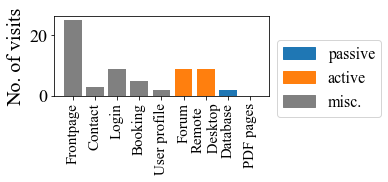

In [62]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=16)
plt.rcParams["font.family"] = "Times New Roman"

fig = plt.figure(figsize=(5.5,2.5))
sorted_pages = []
for pType in allPageTypes:
    sorted_pages += [i for i in pageTypes if pageTypes[i] == pType]
plt.bar([abbrevs[i] for i in sorted_pages],
        [active_inital[i] if i in active_inital else 0 for i in sorted_pages],
        color=[pTypeColors[pageTypes[i]] for i in sorted_pages])
plt.xticks(rotation=90)
patches = [mpatches.Patch(color=pTypeColors[c], label=c) for c in pTypeColors]
ax = plt.gca()
ax.legend(handles=patches, bbox_to_anchor=(1, 0.8))
ax.set_ylabel("No. of visits")
plt.tight_layout()
plt.savefig("./img/active_init_wLegend.png", dpi=300)
plt.show()

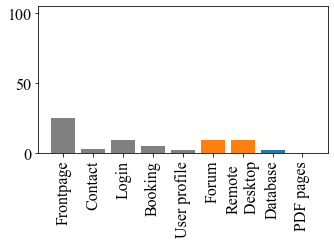

In [63]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rcParams["font.family"] = "Times New Roman"

fig = plt.figure(figsize=(4.75,3.5))
sorted_pages = []
for pType in allPageTypes:
    sorted_pages += [i for i in pageTypes if pageTypes[i] == pType]
plt.bar([abbrevs[i] for i in sorted_pages],
        [active_inital[i] if i in active_inital else 0 for i in sorted_pages],
        color=[pTypeColors[pageTypes[i]] for i in sorted_pages])
plt.xticks(rotation=90)
patches = [mpatches.Patch(color=pTypeColors[c], label=c) for c in pTypeColors]
ax = plt.gca()
#ax.set_ylabel("No. of visits")
ax.set_ylim([0, 105])
plt.tight_layout()
plt.savefig("./img/active_init.png", dpi=300)
plt.show()

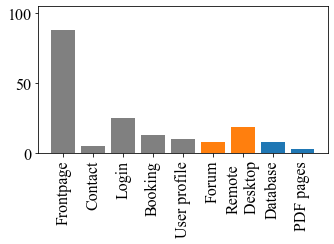

In [64]:
fig = plt.figure(figsize=(4.75,3.5))
sorted_pages = []
for pType in allPageTypes:
    sorted_pages += [i for i in pageTypes if pageTypes[i] == pType]
plt.bar([abbrevs[i] for i in sorted_pages],
        [nonactive_inital[i] if i in nonactive_inital else 0 for i in sorted_pages],
        color=[pTypeColors[pageTypes[i]] for i in sorted_pages])
plt.xticks(rotation=90)
patches = [mpatches.Patch(color=pTypeColors[c], label=c) for c in pTypeColors]
ax = plt.gca()
#ax.set_ylabel("No. of visits")
ax.set_ylim([0, 105])
plt.tight_layout()
plt.savefig("./img/nonactive_init.png", dpi=300)
plt.show()

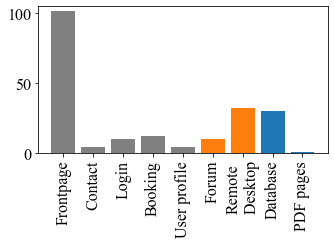

In [65]:
fig = plt.figure(figsize=(4.75,3.5))
sorted_pages = []
for pType in allPageTypes:
    sorted_pages += [i for i in pageTypes if pageTypes[i] == pType]
plt.bar([abbrevs[i] for i in sorted_pages],
        [active_recur[i] if i in active_recur else 0 for i in sorted_pages],
        color=[pTypeColors[pageTypes[i]] for i in sorted_pages])
plt.xticks(rotation=90)
patches = [mpatches.Patch(color=pTypeColors[c], label=c) for c in pTypeColors]
ax = plt.gca()
#ax.set_ylabel("No. of visits")
ax.set_ylim([0, 105])
plt.tight_layout()
plt.savefig("./img/active_recur.png", dpi=300)
plt.show()

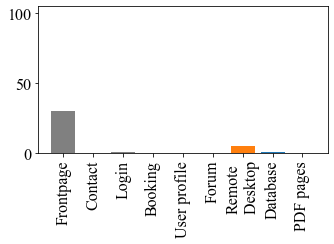

In [66]:
fig = plt.figure(figsize=(4.75,3.5))
sorted_pages = []
for pType in allPageTypes:
    sorted_pages += [i for i in pageTypes if pageTypes[i] == pType]
plt.bar([abbrevs[i] for i in sorted_pages],
        [nonactive_recur[i] if i in nonactive_recur else 0 for i in sorted_pages],
        color=[pTypeColors[pageTypes[i]] for i in sorted_pages])
plt.xticks(rotation=90)
patches = [mpatches.Patch(color=pTypeColors[c], label=c) for c in pTypeColors]
ax = plt.gca()
#ax.set_ylabel("No. of visits")
ax.set_ylim([0, 105])
plt.tight_layout()
plt.savefig("./img/nonactive_recur.png", dpi=300)
plt.show()

In [67]:
def finite_state_data(df):
    menu_dur, item_dur = [], []
    menu_to_item_count, item_to_menu_count = 0, 0
    menu_to_other_count, item_to_other_count = 0, 0
    menu_to_exit_count, item_to_exit_count = 0, 0
    for sess in set(df['sessID']):
        menu_to_item, item_to_menu = [], []
        menu_to_other, item_to_other = [], []
        menu_to_exit, item_to_exit = [], []
        index = df[df['sessID'] == sess].index.tolist()
        #print([i for i in index])
        navList = [df.loc[i]['context'] for i in index]
        
        # for from menu
        ptr, start_i = navList[0], None
        for i in range(len(navList)):
            if navList[i] == "/" and start_i is None:
                start_i = i
            elif navList[i] == "/info" and start_i is not None:
                menu_to_item.append([start_i, i])
                start_i = None
            elif navList[i] != "/" and start_i is not None:
                menu_to_other.append([start_i, i])
                start_i = None
            elif i == len(navList)-1:
                menu_to_exit.append([start_i, i])
                
        # for from item
        ptr, start_i = navList[0], None
        for i in range(len(navList)):
            if navList[i] == "/info" and start_i is None:
                start_i = i
            elif navList[i] == "/" and start_i is not None:
                item_to_menu.append([start_i, i])
                start_i = None
            elif navList[i] != "/info" and start_i is not None:
                item_to_other.append([start_i, i])
                start_i = None
            elif i == len(navList)-1:
                item_to_exit.append([start_i, i])
                
        # measure and store
        menu_to_item_count += len(menu_to_item)
        item_to_menu_count += len(item_to_menu)
        menu_to_other_count += len(menu_to_other)
        item_to_other_count += len(item_to_other)
        menu_to_exit_count += len(menu_to_exit)
        item_to_exit_count += len(item_to_exit)
        for [i,j] in menu_to_item:
            dt_i, dt_j = df.loc[index[i]]['dt'], df.loc[index[j]]['dt']
            dt_i = datetime.strptime(dt_i.split(".")[0], '%Y-%m-%d %H:%M:%S')
            dt_j = datetime.strptime(dt_j.split(".")[0], '%Y-%m-%d %H:%M:%S')
            menu_dur.append(int((dt_j-dt_i).total_seconds()))
        for [i,j] in item_to_menu:
            dt_i, dt_j = df.loc[index[i]]['dt'], df.loc[index[j]]['dt']
            dt_i = datetime.strptime(dt_i.split(".")[0], '%Y-%m-%d %H:%M:%S')
            dt_j = datetime.strptime(dt_j.split(".")[0], '%Y-%m-%d %H:%M:%S')
            item_dur.append(int((dt_j-dt_i).total_seconds()))
    return menu_dur, item_dur, menu_to_item_count, item_to_menu_count, menu_to_other_count, item_to_other_count, menu_to_exit_count, item_to_exit_count

In [68]:
menu_dur, item_dur, menu_item_count, item_menu_count, menu_other_count, item_other_count, menu_exit_count, item_exit_count = finite_state_data(df[(df['is-active'] == True)])
print("active:")
print("menu item count: {}, item menu count: {}".format(menu_item_count, item_menu_count))
print("menu other count: {}, item other count: {}".format(menu_other_count, item_other_count))
print("menu exit count: {}, item exit count: {}".format(menu_exit_count, item_exit_count))
print("menu dur: {}, item dur: {}".format(np.mean(menu_dur), np.mean(item_dur)))

menu_dur, item_dur, menu_item_count, item_menu_count, menu_other_count, item_other_count, menu_exit_count, item_exit_count = finite_state_data(df[(df['is-active'] == False)])
print("non active:")
print("menu item count: {}, item menu count: {}".format(menu_item_count, item_menu_count))
print("menu other count: {}, item other count: {}".format(menu_other_count, item_other_count))
print("menu exit count: {}, item exit count: {}".format(menu_exit_count, item_exit_count))
print("menu dur: {}, item dur: {}".format(np.mean(menu_dur), np.mean(item_dur)))

active:
menu item count: 29, item menu count: 18
menu other count: 85, item other count: 7
menu exit count: 28, item exit count: 56
menu dur: 158.13793103448276, item dur: 70.94444444444444
non active:
menu item count: 9, item menu count: 3
menu other count: 64, item other count: 6
menu exit count: 19, item exit count: 79
menu dur: 21.333333333333332, item dur: 14.666666666666666
